<a href="https://www.kaggle.com/code/taha3012000/bone-fracture-detection?scriptVersionId=253575608" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from PIL import Image
import yaml
from glob import glob
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import shutil
import cv2
import tensorflow
from tensorflow.keras.preprocessing import image_dataset_from_directory
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "iframe_connected"
import matplotlib.patches as patches
import random
from collections import Counter

2025-07-31 22:53:42.439112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754002422.698393      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754002422.770865      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
! pip install ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [3]:
train_path='/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/train/'
val_path='/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/valid/'
test_path='/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/test/'

In [4]:
image_size=(124,124)
batch_size=16
random_seed=42
train_dataset=image_dataset_from_directory(train_path,
                                           batch_size=batch_size,
                                           image_size=image_size,
                                           validation_split=0.2,
                                           subset="training",
                                           shuffle=True,
                                           seed=random_seed)

val_dataset=image_dataset_from_directory(val_path,
                                           batch_size=batch_size,
                                           image_size=image_size,
                                           validation_split=0.2,
                                           subset="validation",
                                           shuffle=True,
                                           seed=random_seed)

test_dataset=image_dataset_from_directory(test_path,
                                           batch_size=batch_size,
                                           image_size=image_size,
                                           shuffle=True,
                                           seed=random_seed)

Found 3631 files belonging to 2 classes.
Using 2905 files for training.


2025-07-31 22:55:52.294830: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 348 files belonging to 2 classes.
Using 69 files for validation.
Found 169 files belonging to 2 classes.


In [5]:
train_dataset.class_names

['images', 'labels']

In [6]:
fig = make_subplots(rows=3, cols=3, subplot_titles=[f"Image {i+1}" for i in range(9)])
for images, labels in train_dataset.take(1):
    for i in range(9):
        row = i // 3 + 1
        col = i % 3 + 1
        img = images[i].numpy().astype("uint8")

        fig.add_trace(
            go.Image(z=img),
            row=row,
            col=col
        )

fig.update_layout(height=1200, width=1000, showlegend=False)
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)

fig.show()

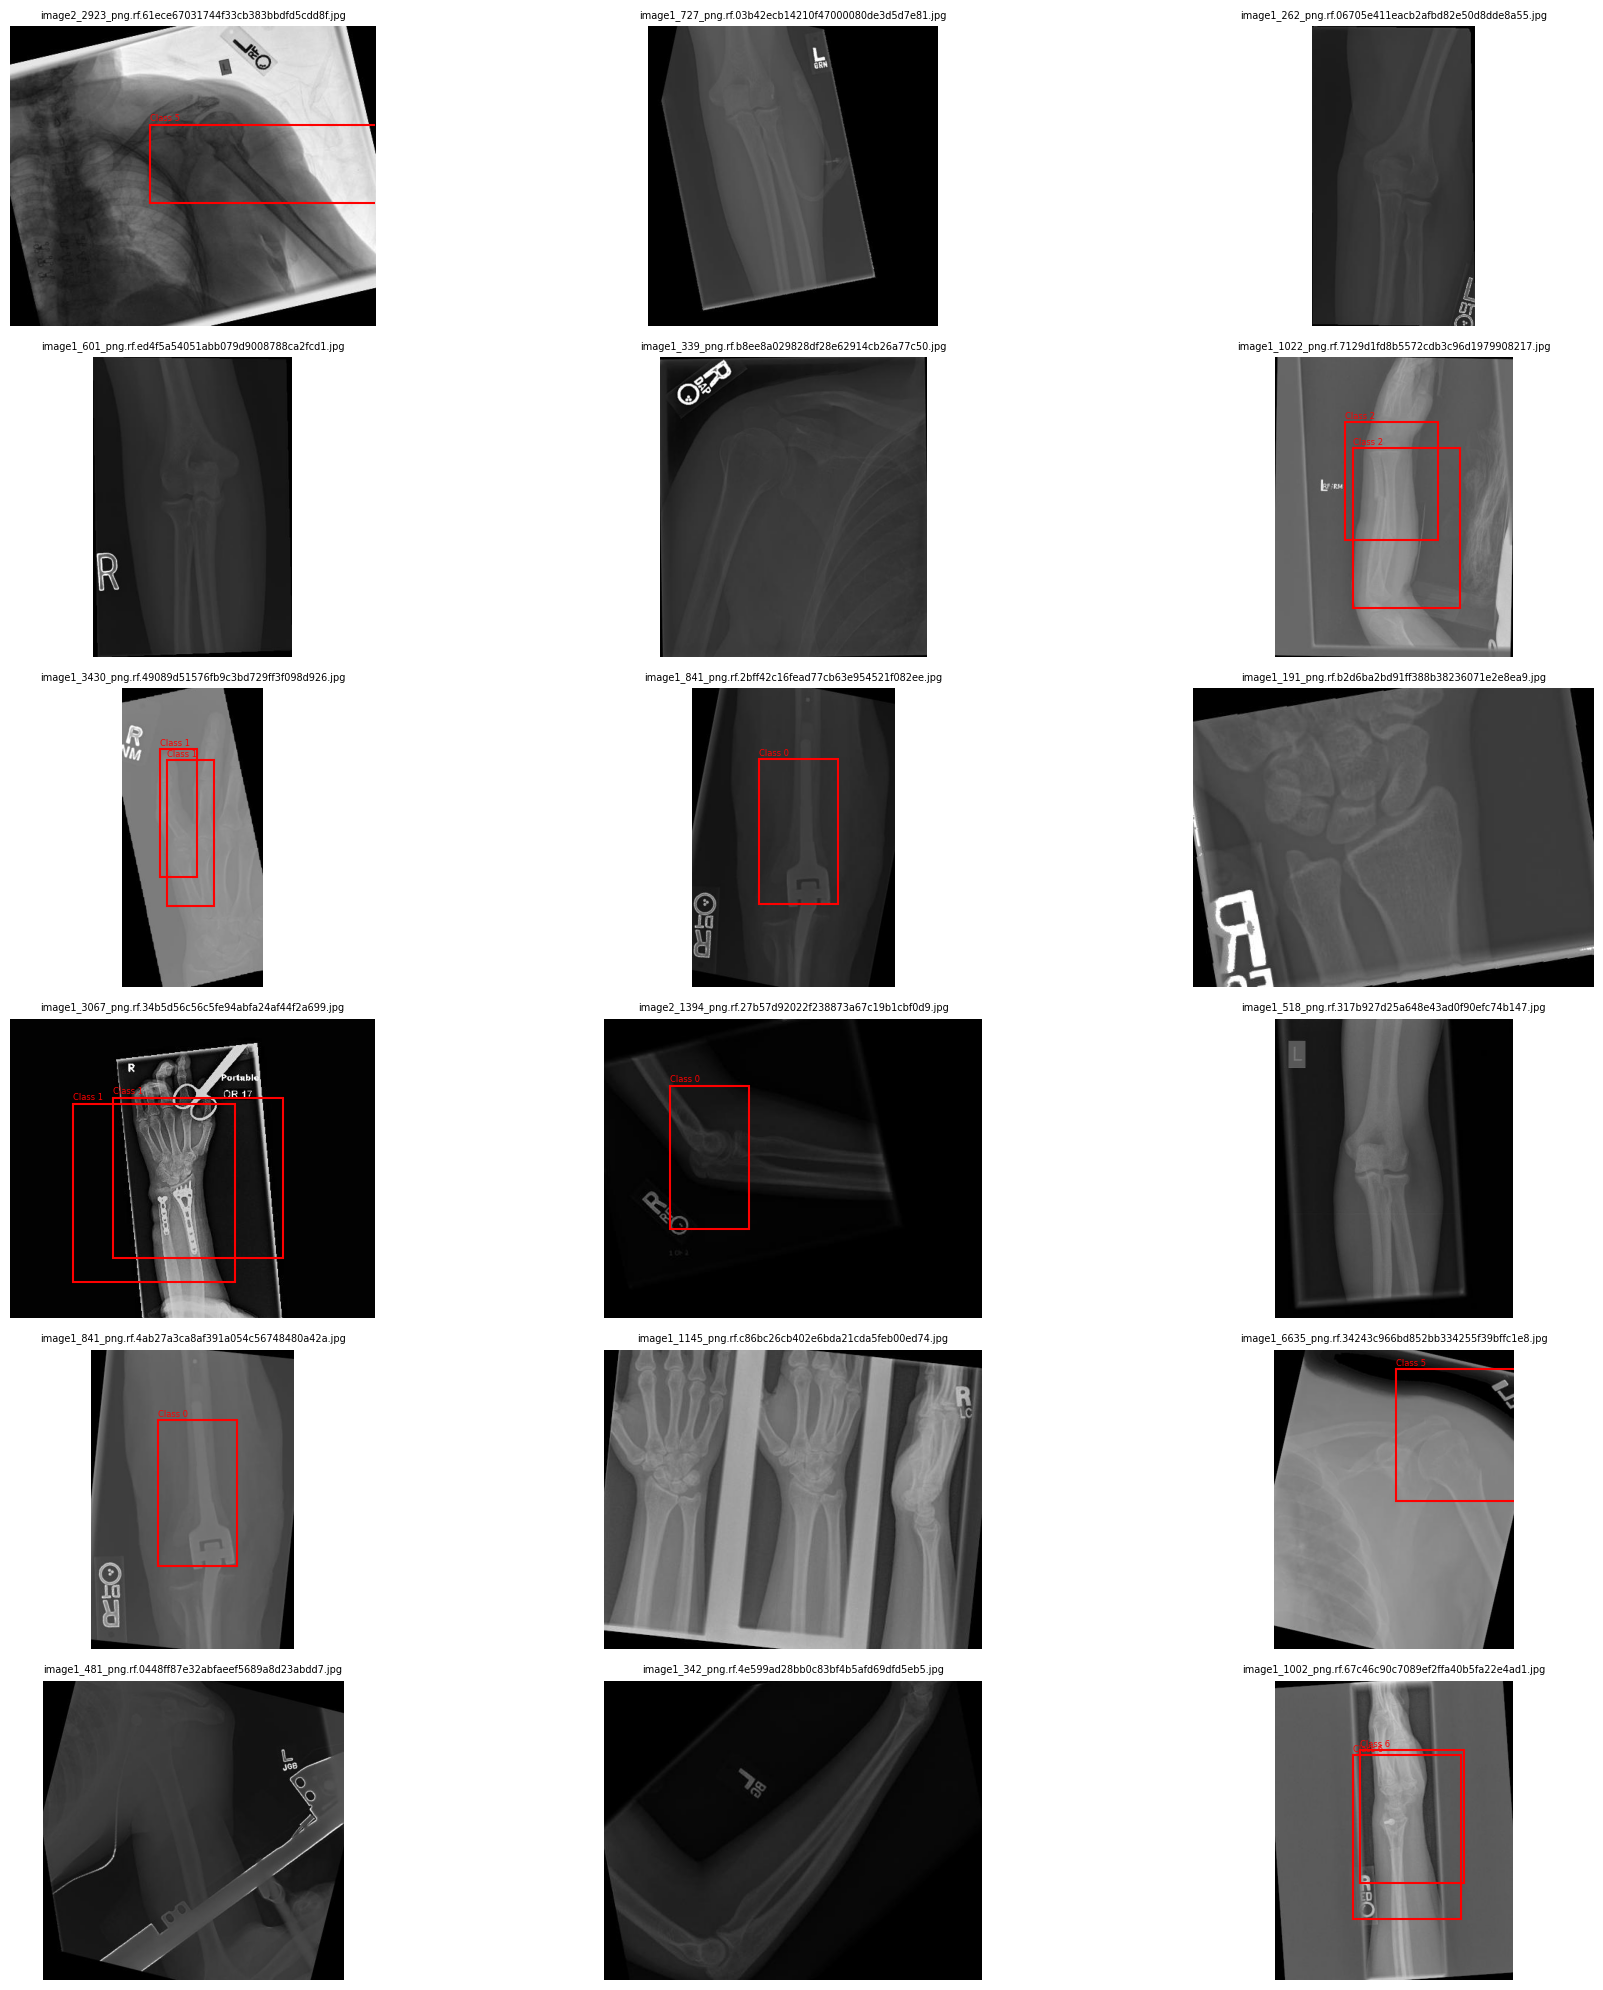

In [7]:
base_dir = "/kaggle/input/bone-fracture-detection-computer-vision-project"
dataset_dir = "bone fracture detection.v4-v4.yolov8"

image_dir = os.path.join(base_dir, dataset_dir, "train/images")
label_dir = os.path.join(base_dir, dataset_dir, "train/labels")

image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

random_images = random.sample(image_files, 18)

plt.figure(figsize=(20, 20))

for idx, filename in enumerate(random_images):
    image_path = os.path.join(image_dir, filename)
    label_path = os.path.join(label_dir, filename.replace(".jpg", ".txt"))
    
    image = Image.open(image_path)
    width, height = image.size

    bboxes = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                class_id = int(parts[0])
                x_center = float(parts[1]) * width
                y_center = float(parts[2]) * height
                w = float(parts[3]) * width
                h = float(parts[4]) * height
                x = x_center - w / 2
                y = y_center - h / 2
                bboxes.append((x, y, w, h, class_id))

    ax = plt.subplot(6, 3, idx + 1)
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(filename, fontsize=7)

    for bbox in bboxes:
        x, y, w, h, class_id = bbox
        rect = patches.Rectangle((x, y), w, h, linewidth=1.5, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y - 5, f"Class {class_id}", color='red', fontsize=6)

plt.tight_layout()
plt.show()


In [8]:
image_dir = "/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/train/images"
label_dir = "/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/train/labels"

image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
total_images = len(image_files)

images_with_labels = 0
images_without_labels = 0
class_counts = Counter()

for img_name in image_files:
    label_name = img_name.replace(".jpg", ".txt")
    label_path = os.path.join(label_dir, label_name)
    
    if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
        images_with_labels += 1
        
        with open(label_path, 'r') as f:
            for line in f:
                class_id = line.strip().split()[0]
                class_counts[class_id] += 1
    else:
        images_without_labels += 1

print(f"Total Images: {total_images}")
print(f"Images with labels: {images_with_labels}")
print(f"Images without labels: {images_without_labels}")
print("\nClass distribution (by YOLO class IDs):")
for class_id, count in class_counts.items():
    print(f"Class {class_id}: {count} instances")

Total Images: 3631
Images with labels: 1804
Images without labels: 1827

Class distribution (by YOLO class IDs):
Class 0: 339 instances
Class 1: 531 instances
Class 5: 360 instances
Class 2: 316 instances
Class 4: 311 instances
Class 6: 228 instances
Class 3: 3 instances


In [9]:
yaml_path = "/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/data.yaml"
with open(yaml_path, "r") as f:
    data_yaml = yaml.safe_load(f)

class_names = data_yaml["names"] 

In [10]:
df_counts = pd.DataFrame({
    "Class ID": list(class_counts.keys()),
    "Count":list(class_counts.values())
})
df_counts["Class Name"] = df_counts["Class ID"].apply(lambda x: class_names[int(x)])

In [11]:
label_dir = "/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/train/labels"
txt_files = glob(os.path.join(label_dir, "*.txt"))

data = []

for file_path in txt_files:
    with open(file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = list(map(float, line.strip().split()))
            if len(parts) >= 11:  # class_id + 5 points = 11 values
                class_id = int(parts[0])
                coords = parts[1:]
                xs = coords[0::2]
                ys = coords[1::2]
                min_x, max_x = min(xs), max(xs)
                min_y, max_y = min(ys), max(ys)
                w = max_x - min_x
                h = max_y - min_y
                x_center = min_x + w / 2
                y_center = min_y + h / 2
                area = w * h
                data.append({
                    "Image": os.path.basename(file_path).replace(".txt", ".jpg"),
                    "Class ID": class_id,
                    "x_center": x_center,
                    "y_center": y_center,
                    "width": w,
                    "height": h,
                    "Box Area": area
                })

df = pd.DataFrame(data)
print({len(df)})
df.head()

{1478}


,Image,Class ID,x_center,y_center,width,height,Box Area
0,image1_2748_png.rf.568ada7b8ae0b71f076663983e4...,1,0.675959,0.550262,0.107426,0.042637,0.004580
1,image1_1952_png.rf.affb8c1eef1e6fb8ef0eb5dbb34...,1,0.462755,0.272901,0.086844,0.084668,0.007353
2,image2_738_png.rf.9d550fec27301122da0d16121329...,4,0.759377,0.515181,0.245685,0.220547,0.054185
3,image1_4692_png.rf.7c9128649d7b28d495e7fe2de01...,0,0.370883,0.641516,0.188657,0.201563,0.038026
4,image1_383_png.rf.0df3bddab531201fb746523991b4...,1,0.520459,0.448481,0.603735,0.135350,0.081715


In [12]:
fig = px.box(df, x="Class ID", y="Box Area",
             title="Box Area Distribution by Fracture Type")
fig.update_layout(xaxis_title="Fracture Class", yaxis_title="Area", xaxis_tickangle=-45)
fig.show()

In [13]:
fig = px.bar(
    df_counts,
    x="Class Name",
    y="Count",
    title="Distribution of Fracture Classes",
    color="Class Name",
    text="Count",
    template="plotly_white"
)

fig.update_traces(textposition="outside")
fig.update_layout(
    xaxis_title="Fracture Type",
    yaxis_title="Number of Instances",
    showlegend=False,
    height=500,
    width=800
)

fig.show()

In [14]:
import plotly.figure_factory as ff

x_vals = df["x_center"]
y_vals = df["y_center"]

fig = ff.create_2d_density(
    x_vals, y_vals, 
    colorscale='Hot', 
    hist_color='rgb(255, 255, 255)',
    point_size=1,
    title='Fracture Location Heatmap (Normalized)'
)

fig.update_layout(xaxis_title="x_center", yaxis_title="y_center", yaxis_autorange='reversed')
fig.show()

In [15]:
class_counts = df["Class ID"].value_counts().reset_index()
class_counts.columns = ["Class ID", "Count"]

fig = px.bar(class_counts,
             x="Class ID", y="Count",
             title="Fracture Type Counts",
             labels={"Class ID": "Fracture Class", "Count": "Number of Instances"})

fig.show()

In [16]:
train_images = glob(os.path.join(train_path, "*.jpg"))
test_images = glob(os.path.join(test_path, "*.jpg"))

train_count = len(train_images)
test_count = len(test_images)

df_split = pd.DataFrame({
    "Set": ["Train", "Test"],
    "Count": [train_count, test_count]
})

fig = px.pie(df_split, names="Set", values="Count", title="Train/Test Image Distribution")
fig.show()

In [17]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  

# تدريب
model.train(
    data="/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/data.yaml", 
    epochs=10,
    imgsz=640,
    batch=32,
    name="fracture_yolov8"
)

100%|██████████| 6.25M/6.25M [00:00<00:00, 82.5MB/s]


Ultralytics 8.3.171 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fracture_yolov8, nbs=64, nms=False, opset=None, optimize=False, optimizer=aut

100%|██████████| 755k/755k [00:00<00:00, 17.8MB/s]


Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/train/labels... 3631 images, 1827 backgrounds, 0 corrupt: 100%|██████████| 3631/3631 [00:10<00:00, 339.11it/s]


WARNING ⚠️ train: Cache directory /kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 1.8±0.5 MB/s, size: 9.2 KB)


val: Scanning /kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/valid/labels... 348 images, 175 backgrounds, 0 corrupt: 100%|██████████| 348/348 [00:01<00:00, 262.34it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/valid is not writeable, cache not saved.


Plotting labels to runs/detect/fracture_yolov8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/fracture_yolov8
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G       2.86      8.719       2.49         10        640: 100%|██████████| 114/114 [30:18<00:00, 15.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:48<00:00,  8.08s/it]

                   all        348        204   0.000575      0.258    0.00155   0.000349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      2.558      6.382       2.17         11        640: 100%|██████████| 114/114 [32:42<00:00, 17.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:53<00:00,  8.97s/it]

                   all        348        204      0.844    0.00388    0.00537    0.00128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      2.438       4.94       2.16          7        640: 100%|██████████| 114/114 [31:55<00:00, 16.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:44<00:00,  7.39s/it]

                   all        348        204      0.765     0.0255     0.0351    0.00927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      2.375      4.164      2.119         10        640: 100%|██████████| 114/114 [32:15<00:00, 16.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:44<00:00,  7.33s/it]

                   all        348        204      0.136     0.0502     0.0624     0.0209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G       2.32      3.727      2.103          8        640: 100%|██████████| 114/114 [31:00<00:00, 16.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:45<00:00,  7.54s/it]

                   all        348        204       0.17      0.107     0.0758     0.0262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      2.221      3.346      2.093         11        640: 100%|██████████| 114/114 [31:27<00:00, 16.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:40<00:00,  6.79s/it]

                   all        348        204      0.233      0.146      0.129     0.0465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      2.186       3.07       2.05         11        640: 100%|██████████| 114/114 [30:14<00:00, 15.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:43<00:00,  7.20s/it]

                   all        348        204      0.211       0.18      0.145     0.0519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G       2.08       2.82      1.975          7        640: 100%|██████████| 114/114 [29:10<00:00, 15.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:41<00:00,  6.96s/it]

                   all        348        204      0.299      0.201      0.191     0.0625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      2.002      2.669        1.9          5        640: 100%|██████████| 114/114 [29:15<00:00, 15.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:41<00:00,  6.90s/it]

                   all        348        204      0.333      0.224      0.216     0.0783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.959      2.461      1.869          9        640: 100%|██████████| 114/114 [30:24<00:00, 16.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:41<00:00,  6.88s/it]

                   all        348        204      0.305      0.247      0.216      0.084



10 epochs completed in 5.271 hours.
Optimizer stripped from runs/detect/fracture_yolov8/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/fracture_yolov8/weights/best.pt, 6.2MB

Validating runs/detect/fracture_yolov8/weights/best.pt...
Ultralytics 8.3.171 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:36<00:00,  6.12s/it]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning:

invalid value encountered in less



                   all        348        204      0.299      0.248      0.216     0.0843
        elbow positive         28         29      0.263     0.0745      0.101     0.0369
      fingers positive         41         48      0.211      0.167      0.131      0.044
      forearm fracture         37         43      0.355      0.558      0.426      0.191
               humerus         31         36      0.498      0.417      0.433      0.163
     shoulder fracture         19         20      0.168        0.2      0.109     0.0338
        wrist positive         17         28      0.297     0.0714      0.099     0.0371
Speed: 1.1ms preprocess, 96.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/fracture_yolov8


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a3bc927cf90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

In [18]:
metrics = model.val(
    data="/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/data.yaml", 
    split="val"
)

Ultralytics 8.3.171 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 15.4±5.1 MB/s, size: 11.0 KB)


val: Scanning /kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/valid/labels... 348 images, 175 backgrounds, 0 corrupt: 100%|██████████| 348/348 [00:00<00:00, 639.99it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/valid is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:36<00:00,  3.33s/it]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning:

invalid value encountered in less



                   all        348        204      0.325      0.247      0.217     0.0836
        elbow positive         28         29      0.257      0.069     0.0968     0.0362
      fingers positive         41         48      0.298      0.167      0.145     0.0464
      forearm fracture         37         43      0.348      0.558      0.424       0.19
               humerus         31         36      0.507      0.417      0.433      0.166
     shoulder fracture         19         20      0.192        0.2      0.109     0.0336
        wrist positive         17         28       0.35     0.0714     0.0928     0.0292
Speed: 0.9ms preprocess, 96.6ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/fracture_yolov82


In [19]:
results = model.predict(
    source="/kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/test/images",
    save=True,           
    conf=0.25,           
    imgsz=640        
)


image 1/169 /kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/test/images/distal-humerus-fracture-1_jpg.rf.831cb137cfcbde1079f86abd5f5f2867.jpg: 640x256 (no detections), 106.2ms
image 2/169 /kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/test/images/image1_0_png.rf.99862308d714bff3f9c410adf5ca93ac.jpg: 480x640 (no detections), 146.8ms
image 3/169 /kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/test/images/image1_1000_png.rf.a53c5e186c03961bf88075c6e3e94cf6.jpg: 544x640 (no detections), 159.6ms
image 4/169 /kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/test/images/image1_1015_png.rf.3b7320c3c40771fa5532bf713a728b83.jpg: 544x640 1 shoulder fracture, 126.2ms
image 5/169 /kaggle/input/bone-fracture-detection-computer-vision-project/bone fracture detection.v4-v4.yolov8/test/images/image1_10